# Volatility Arbitrage Strategy

In [1]:
# import necessary libraries
import pandas as pd

# import class object under Code folder
from Code.data_cleaning import data_cleaning
from Code.implied_vol import BS_implied_vol
from Code.fit_bs import fit_BS

## Data Cleaning

- retrieve spx option data from Bloomberg
- retrieve spx index data from yhoo finance
- clean data
  - unnecessary rows and columns
  - option ticker breakdown
  - expiration date format
  - keep options with certain expiration date which have more than 10 implied volatility
  - save the term structure of options
  - use the mid price of bid and ask as the option price
  - only use SPX data not SPXW data


In [2]:
raw_data = pd.read_csv('./Public/data/option_price/20230901/spx_option_0901.csv')
option_data = data_cleaning(raw_data).format_data()
option_data = data_cleaning(option_data).check_iv_number()
spx_data = data_cleaning(option_data).get_spx_hist('2021-09-01', '2023-11-13')
option_price = data_cleaning(option_data).extract_option_price()

display(option_data.head())
display(spx_data.head())
display(option_price.head())

,Ticker,Index,Type,Expiry,Strike,Bid,Ask,Last,Volm,IVM
0,SPX 9/15/23 C4470,SPX,C,2023-09-15,4470,66.699997,67.699997,68.380005,16.0,10.665597
1,SPX 9/15/23 C4475,SPX,C,2023-09-15,4475,62.900009,63.900009,61.449997,18.0,10.570473
2,SPX 9/15/23 C4480,SPX,C,2023-09-15,4480,59.100006,60.199997,53.169998,6.0,10.464067
3,SPX 9/15/23 C4490,SPX,C,2023-09-15,4490,52.000000,53.000000,52.119995,11.0,10.279760
4,SPX 9/15/23 C4495,SPX,C,2023-09-15,4495,48.599991,49.599991,48.669998,6.0,10.197698


,Open
Date,
2021-09-01,4528.799805
2021-09-02,4534.479980
2021-09-03,4532.419922
2021-09-07,4535.379883
2021-09-08,4518.089844


,Index,Strike,Expiry,c,p
0,SPX,4470,2023-09-15,67.199997,16.199997
1,SPX,4475,2023-09-15,63.400009,17.400002
2,SPX,4480,2023-09-15,59.650002,18.649994
3,SPX,4490,2023-09-15,52.500000,21.449997
4,SPX,4495,2023-09-15,49.099991,23.000000


## Find BS Implied Volatility

- use put-call parity to calculate the risk-free rate and dividend yield for spx index option
  - for different expiration date, the implied risk-free rate are different. 
    $$
    C-P = S_0e^{-qT}-Ke^{-rT}\\
    C-P = e^{-rT}(S_0e^{(r-q)T}-K) = e^{-r}(F_{(0, T)}-K)\\
    \text{where }F_{(0,T)}:=S_0e^{(r-q)T}, \text{ which is the forward price at time 0 with maturity T. }
    $$
  - get rid of outlier and abnormal value, implied risk-free rate are the average of the rest
    $$
      r_{risk-free, implied} = \frac{1}{N}\sum_{i=1}^N r_i, \quad r_i \in [r_{min}, r_{max}]
    $$
- use Black-Scholes model to calculate the implied volatility for each option
  - Black-Scholes model using forward price, the formula is:
    $$
    C(t) = e^{-r(T-t)}(F_{(t, T)}\Phi(d_1)-K\Phi(d_2))\\
    P(t) = e^{-r(T-t)}(K\Phi(-d_2)-F_{(t, T)}\Phi(-d_1))\\
    \displaystyle\text{where }d_1 = \frac{\ln(\frac{F_{(t, T)}}{K})+\frac{1}{2}\sigma^2T}{\sigma\sqrt{T}},\quad d_2 = d_1-\sigma\sqrt{T}, \quad \phi() \text{ is the standard normal pdf}\\
    \text{and }F_{(t, T)}:=S_0e^{(r-q)(T-t)}, \text{ which is the forward price at time 0 with maturity T. }
    
    $$
  - Use bisection method to get the implied volatility.   
    $$
      \sigma_{implied}(F_{(0, T)}, K, T, r, c) = \sigma_{implied}(F_{(0, T)}, K, T, r, p)\\
    $$

- Calculate forward moneyness for each option
  $$
  \text{forward moneyness} = \ln\left(\frac{K}{F_{(0,T)}}\right)
  $$
  - The forward price for each maturity is different. 


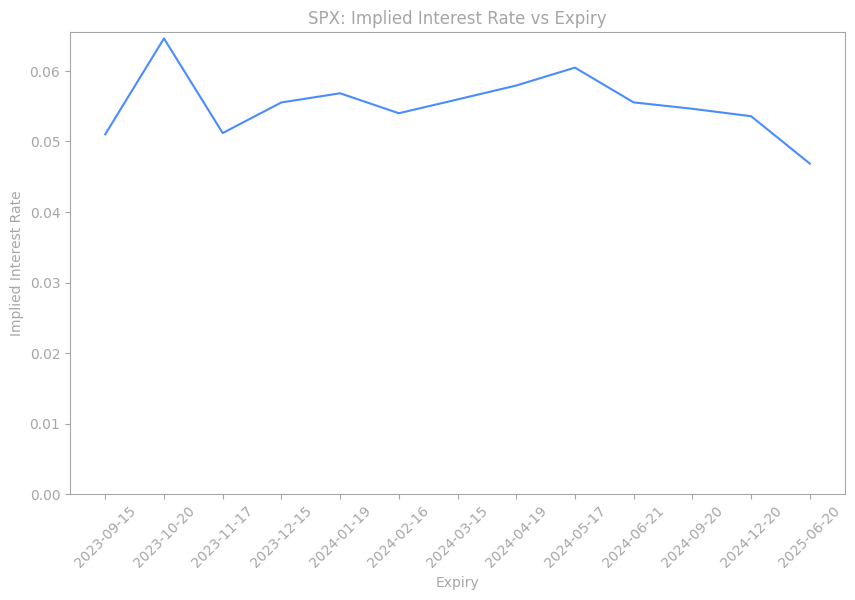

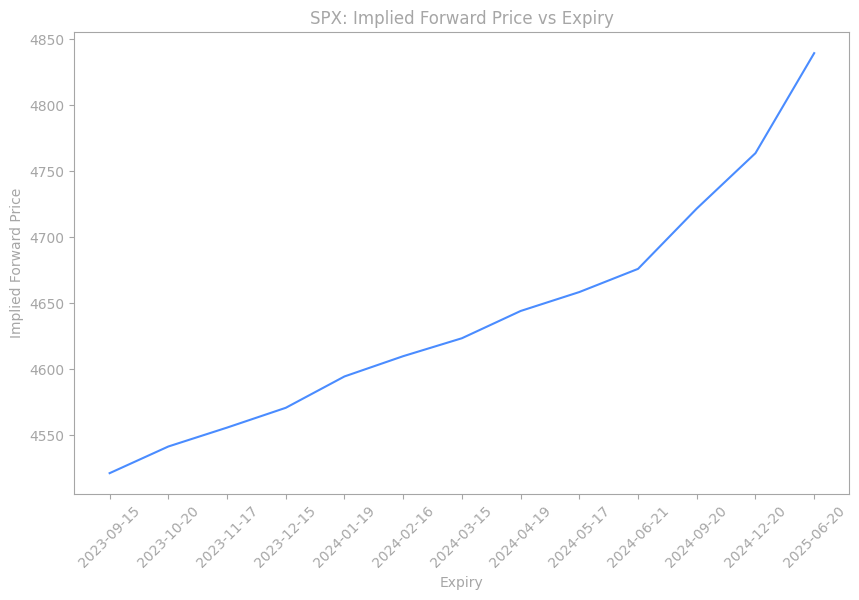

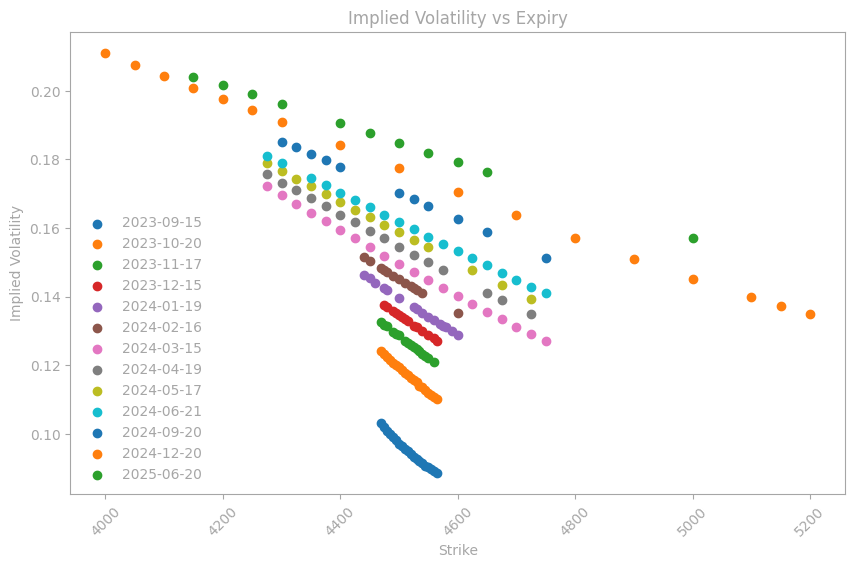

,Index,Expiry,implied_ir,implied_fwd
0,SPX,2023-09-15,0.051018,4521.108973
1,SPX,2023-10-20,0.064610,4541.316310
2,SPX,2023-11-17,0.051196,4555.638916
3,SPX,2023-12-15,0.055533,4570.635823
4,SPX,2024-01-19,0.056832,4594.397578


In [3]:
implied_params = BS_implied_vol(option_price).parity_implied_params(option_data, plot_parity=False)
BS_implied_vol(option_price).plot_ir(implied_params)
BS_implied_vol(option_price).plot_fwd(implied_params)
implied_vol = BS_implied_vol(option_price).get_iv(option_data, implied_params, spx_data, plot_iv_scatter=True)

display(implied_params.head())

In [4]:
# calculate forward moneyness
fwd_moneyness = pd.DataFrame(columns=implied_params['Expiry'].unique())
fwd_moneyness.loc['implied_fwd'] = implied_params['implied_fwd'].values
strike_list = implied_vol.columns.values.astype(int)

# for each value in the strike, calculate the forward moneyness
for strike in strike_list:
    fwd_moneyness.loc[strike] = strike/fwd_moneyness.loc['implied_fwd']
display(fwd_moneyness.T.head())

,implied_fwd,4000,4050,4100,4150,4200,4250,4275,4300,4325,...,4675,4700,4725,4750,4800,4900,5000,5100,5150,5200
2023-09-15,4521.108973,0.884739,0.895798,0.906857,0.917916,0.928976,0.940035,0.945564,0.951094,0.956624,...,1.034038,1.039568,1.045098,1.050627,1.061686,1.083805,1.105923,1.128042,1.139101,1.150160
2023-10-20,4541.316310,0.880802,0.891812,0.902822,0.913832,0.924842,0.935852,0.941357,0.946862,0.952367,...,1.029437,1.034942,1.040447,1.045952,1.056962,1.078982,1.101002,1.123022,1.134032,1.145042
2023-11-17,4555.638916,0.878033,0.889008,0.899984,0.910959,0.921934,0.932910,0.938397,0.943885,0.949373,...,1.026201,1.031688,1.037176,1.042664,1.053639,1.075590,1.097541,1.119492,1.130467,1.141443
2023-12-15,4570.635823,0.875152,0.886091,0.897031,0.907970,0.918909,0.929849,0.935318,0.940788,0.946258,...,1.022834,1.028303,1.033773,1.039243,1.050182,1.072061,1.093940,1.115818,1.126758,1.137697
2024-01-19,4594.397578,0.870626,0.881508,0.892391,0.903274,0.914157,0.925040,0.930481,0.935922,0.941364,...,1.017544,1.022985,1.028426,1.033868,1.044751,1.066516,1.088282,1.110048,1.120930,1.131813


c:\software\Python312\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\software\Python312\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\software\Python312\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\software\Python312\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\software\Python312\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be e

,2023-09-15,2023-10-20,2023-11-17,2023-12-15,2024-01-19,2024-02-16,2024-03-15,2024-04-19,2024-05-17,2024-06-21,2024-09-20,2024-12-20,2025-06-20
atm_vol,0.093901,0.113349,0.121431,0.126338,0.129517,0.134115,0.137969,0.141562,0.144877,0.146857,0.153322,0.159627,0.165973
delta,7.222186,7.991692,7.881757,7.344811,7.086499,6.779523,6.493115,6.229006,6.033269,5.874117,5.331861,4.643605,3.842428
kappa,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.704913,2.702527,2.700000,2.700000,2.701032,2.700000,2.700000
gamma,-39.352209,-43.546198,-42.947852,-40.021269,-38.614675,-36.941775,-35.441944,-33.970983,-32.873975,-32.006915,-29.060491,-25.308458,-20.931783


C:\Users\gavin\AppData\Local\Temp\ipykernel_7688\2557501226.py:95: RuntimeWarning: invalid value encountered in sqrt
  y[:, i] = np.sqrt(y[:, i])


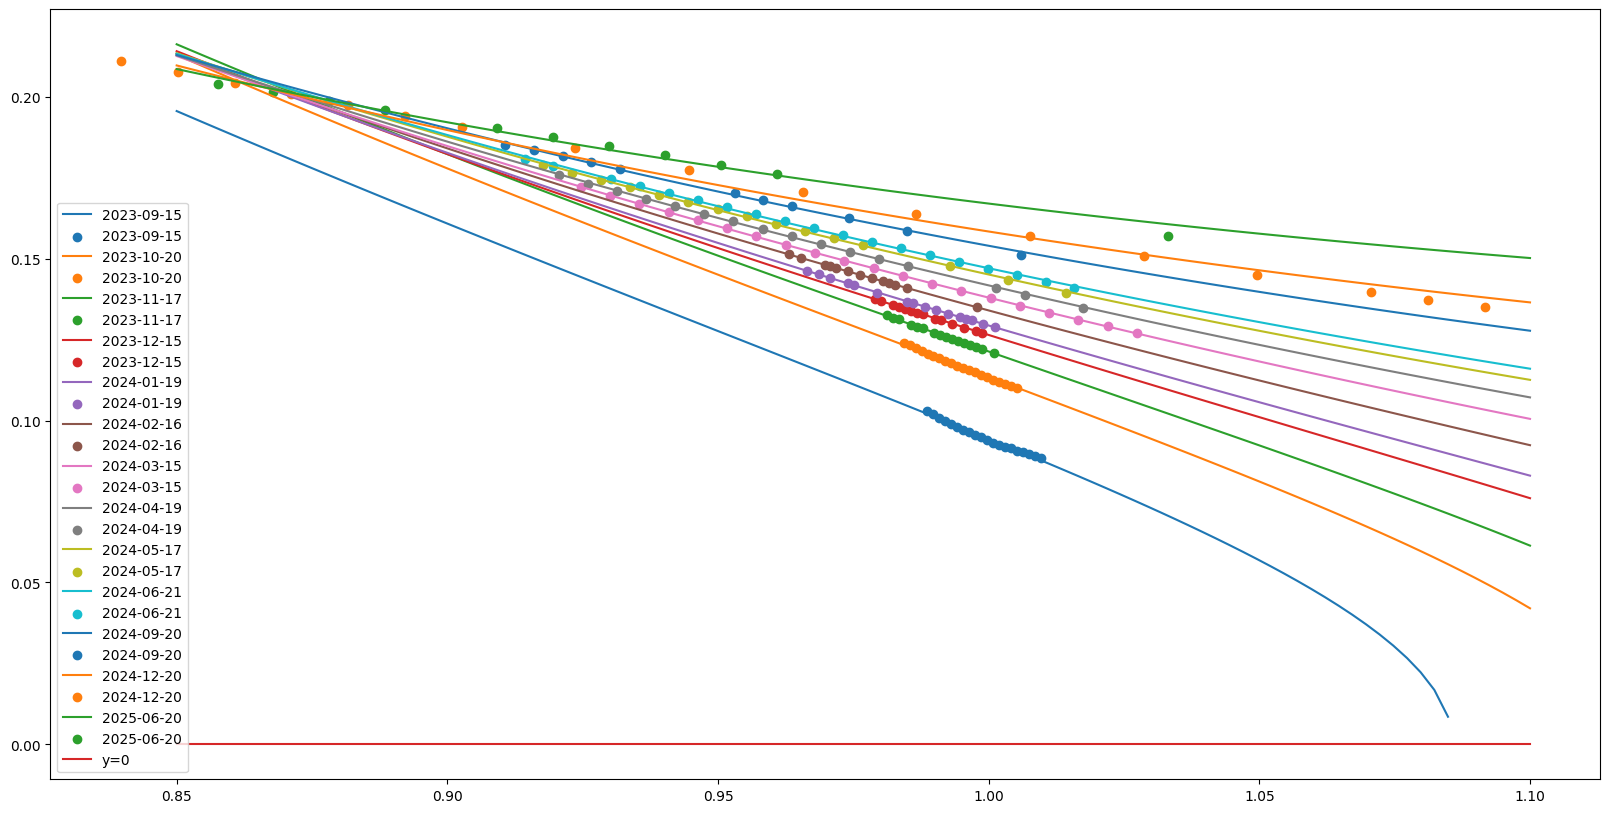

In [5]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

def fir_curve(bounds = ([0, 2.7, -70], [8, 10, -20]), p0=[4, 5, -30]):
    # for each expiry, fit implied vol curve
    expiry_list = implied_vol.columns
    bs_iv_curve_params = pd.DataFrame(columns=['atm_vol', 'delta', 'kappa', 'gamma'])
    for expiry in fwd_moneyness.columns:
    # for expiry in ['2024-12-20']:
        # get fwd mny distribution
        fwd_moneyness_expiry = fwd_moneyness[expiry]
        fwd_moneyness_expiry = fwd_moneyness_expiry.drop(['implied_fwd'])

        # get implied vol
        implied_vol_expiry = implied_vol.T[expiry]
        
        # concat fwd moneyness and implied vol, column name: fwd_moneyness, first row: implied_vol
        implied_vol_fwd_moneyness = pd.DataFrame(columns=fwd_moneyness_expiry.values)
        implied_vol_fwd_moneyness.loc['implied_vol'] = implied_vol_expiry.values
        implied_vol_fwd_moneyness = implied_vol_fwd_moneyness.dropna(axis=1)
        
        # plot the implied vol vs fwd moneyness
        # plt.plot(fwd_moneyness_expiry, implied_vol_expiry.values)
        # plt.title(f'{expiry}')
        # plt.show()

        # get atm implied vol
        def iv_near_1(x, a, b):
            return a * (x) + b

        if 1 not in implied_vol_fwd_moneyness.columns:
            # find 2 columns that column names are closest to 1 in implied_vol_fwd_moneyness
            implied_vol_fwd_moneyness.columns = implied_vol_fwd_moneyness.columns.astype(float)
            atm_fit = implied_vol_fwd_moneyness.iloc[:, abs(implied_vol_fwd_moneyness.columns - 1).argsort()[:2]]

            # fit the curve using 2 implied vol near 1
            fwd_moneyness_near_1_x = atm_fit.columns
            iv_near_1_y = atm_fit.loc['implied_vol'].values
            params, _ = curve_fit(iv_near_1, fwd_moneyness_near_1_x, iv_near_1_y)
            x = 1
            a = params[0]
            b = params[1]
            atm_vol = iv_near_1(x, a, b)
            # print(atm_vol)
        else:
            atm_vol = implied_vol_fwd_expiry.loc[1]
            
        # fit implied vol curve
        def implied_vol_curve(x, delta, kappa, gamma):
            # return np.sqrt(atm_vol**2 + delta * (np.tanh(kappa * x) / kappa) + 0.5 * gamma * (np.tanh(kappa * x) / kappa)**2)
            return atm_vol**2 + delta * (np.tanh(kappa * x) / kappa) + 0.5 * gamma * (np.tanh(kappa * x) / kappa)**2
        
        # get the location of all non-nan values in implied vol
        fwd_moneyness_x = implied_vol_fwd_moneyness.columns.values
        implied_vol_y = implied_vol_fwd_moneyness.loc['implied_vol'].values
        # take log of implied vol
        # implied_vol_y = np.log(implied_vol_y)
        implied_var_y = implied_vol_y ** 2
        # bounds = ([-20, -10, -30], [20, 10, 0])
        
        params, _ = curve_fit(implied_vol_curve, fwd_moneyness_x, implied_var_y, maxfev=1000000, bounds=bounds, p0=p0)
        delta = params[0]
        kappa = params[1]
        gamma = params[2]
        # print function
        # print(f'atm_vol: {atm_vol}')
        # print(f'delta: {delta}')
        # print(f'kappa: {kappa}')
        # print(f'gamma: {gamma}')
        
        # plot the implied vol curve
        # x = np.linspace(0.5, 1.5, 100)
        # y = implied_vol_curve(x, delta, kappa, gamma)
        # plt.plot(x, y)
        # plt.title(f'{expiry}')
        # plt.show()
        
        # store all the parameters in a dataframe named bs_iv_curve_params
        bs_iv_curve_params = pd.concat([bs_iv_curve_params, pd.DataFrame([[atm_vol, delta, kappa, gamma]], columns=['atm_vol', 'delta', 'kappa', 'gamma'])], axis=0)
    bs_iv_curve_params.index = fwd_moneyness.columns
    display(bs_iv_curve_params.T)
        
    # using all the params in bs_iv_curve_params, plot the implied vol curve in one plot
    plt.figure(figsize=(20, 10))
    x = np.linspace(0.85, 1.1, 100)
    y = np.zeros((len(x), len(bs_iv_curve_params.index)))
    i = 0
    for expiry in bs_iv_curve_params.index:
        atm_vol = bs_iv_curve_params.loc[expiry]['atm_vol']
        delta = bs_iv_curve_params.loc[expiry]['delta']
        kappa = bs_iv_curve_params.loc[expiry]['kappa']
        gamma = bs_iv_curve_params.loc[expiry]['gamma']
        y[:, i] = implied_vol_curve(x, delta, kappa, gamma)
        y[:, i] = np.sqrt(y[:, i])
        i += 1
        plt.plot(x, y[:, i-1], label=expiry)
        # plot the scattar plot of implied vol
        # plt.scatter(fwd_moneyness[expiry], implied_vol[expiry], label=expiry)
        fwd_moneyness_expiry = fwd_moneyness[expiry]
        fwd_moneyness_expiry = fwd_moneyness_expiry.drop(['implied_fwd'])
        implied_vol_expiry = implied_vol.T[expiry]
        plt.scatter(fwd_moneyness_expiry, implied_vol_expiry.values, label=expiry)

    # plot y=0 line
    plt.plot(x, np.zeros(len(x)), label='y=0')
    plt.legend()
    plt.show()

fir_curve(p0=[1, 7, -65])

## Fit BS Implied Volatility Surface

- calculate the implied volatility for each option using the implied volatility of the at-the-money forward option with the same expiration date
  - there is no at-the-money forward option data, therefore, fit the nearest 4 implied volatility by linear function, $f(x) = ax + b$ 
- for the same expiration date, fit the implied volatility curve against spot moneyness using function below:
  - option 1: similar to tanh function
    $$
    \sigma(x)^2 = \sigma_{atm}^2 + \delta\displaystyle\left(\frac{\tanh(\kappa x)}{\kappa}\right) + \frac{\gamma}{2}\left(\frac{\tanh(\kappa x)}{\kappa}\right)^2,\quad
    \text{where }x = \displaystyle\ln\left(\frac{K}{S}\right)
    $$
  - option 2: similar to sigmoid function
- for different expiration date, for same moneyness, connect the implied volatility curve using cubic spline interpolation


,2023-09-15,2023-10-20,2023-11-17,2023-12-15,2024-01-19,2024-02-16,2024-03-15,2024-04-19,2024-05-17,2024-06-21,2024-09-20,2024-12-20,2025-06-20
implied_fwd,4521.108973,4541.316310,4555.638916,4570.635823,4594.397578,4609.759777,4623.348187,4644.000761,4658.350784,4675.913084,4721.610184,4763.590394,4839.359375
4000,0.884739,0.880802,0.878033,0.875152,0.870626,0.867724,0.865174,0.861326,0.858673,0.855448,0.847169,0.839703,0.826556
4050,0.895798,0.891812,0.889008,0.886091,0.881508,0.878571,0.875989,0.872093,0.869406,0.866141,0.857758,0.850199,0.836888
4100,0.906857,0.902822,0.899984,0.897031,0.892391,0.889417,0.886803,0.882859,0.880140,0.876834,0.868348,0.860695,0.847220
4150,0.917916,0.913832,0.910959,0.907970,0.903274,0.900264,0.897618,0.893626,0.890873,0.887527,0.878937,0.871192,0.857552


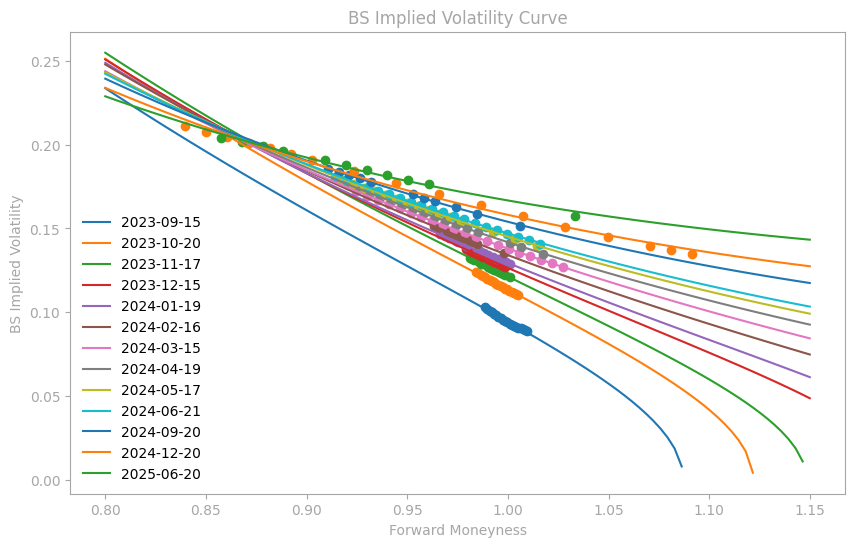

In [6]:
fwd_moneyness_spx = fit_BS(implied_vol, implied_params).get_fwd_mny()
display(fwd_moneyness_spx.head())
bs_iv_curve_params = fit_BS(implied_vol, implied_params).fit_BS_curve(fwd_moneyness_spx, plot_curve=True)


## Convert BS Implied Volatility Surface to Local Volatility Surface

- use Dupire's formula to calculate the local volatility for each option
  $$
  \frac{\partial w}{\partial T} = v_L \left\{1 - \frac{y}{w}\frac{\partial w}{\partial y} + \frac{1}{4}\left(-\frac{1}{4}-\frac{1}{w}+\frac{y^2}{w^2}\right)\left(\frac{\partial w}{\partial y}\right)^2+\frac{1}{2}\frac{\partial^2 w}{\partial y^2}\right\}\\
  \text{where }w:=\text{ Black-Scholes implied variance},\quad y:= \ln\left(\frac{K}{F_T}\right), \quad v_L:=\text{ local volatility}
  $$

## Trading Strategy

- if the implied volatility of an option is higher than the local volatility, then sell the option

## Backtesting

# To-do List
- after delete the rows with 0 volume, the moneyness with near expiration date is close to 0, it is hard to fit the implied volatility curve
- put call parity last price in 2023-09-15, the interest rate is negative. Using last price to calculate the risk-free rate fluctuates a lot. 
- if use put-call parity to get interest rate and forward price, what is the Dupire's formula?  
- how to use spot moneyness to fit the implied volatility curve?
- implied forawrd price is not a linear line. Is there anything wrong?

# Reference

[How to Determine Implied Dividend Yield-Derivative Valuation in Excel](https://derivvaluation.medium.com/how-to-determine-implied-dividend-yield-derivative-valuation-in-excel-1078a9bc1f7f)  
[SPX vs. SPXW Options: Understanding the Key Differences](https://insideoptions.io/spx-spxw-options-differences/)  
[Cubic Spline Interpolation](https://en.wikipedia.org/wiki/Spline_interpolation#Algorithm_to_find_the_interpolating_cubic_spline)  
[Estimation of Implied Interest Rates and Dividend Yields](../volatility_arbitrage/Reference/on_a_robust_estimation_of_option-implied_interest_rates_and_dividend_yields.pdf)  
[Put-Call-Forward Parity](https://analystnotes.com/cfa-study-notes-explain-put-call-forward-parity-for-european-options.html)  
[At-The-Money-Forward option approximation](https://quant.stackexchange.com/questions/35433/at-the-money-forward-option-approximation)  
[What is forward moneyness and how to calculate it?](https://quant.stackexchange.com/questions/43596/what-is-forward-moneyness-and-how-to-calculate-it)  
[At-The-Money Forward](https://www.fincyclopedia.net/derivatives/a/at-the-money-forward)  